In [1]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import numpy as np
import torch

from diffusers import DiffusionPipeline
from diffusers import StableDiffusionPipeline
from pathlib import Path
from itertools import product
from PIL import Image
from io import BytesIO
from sklearn.decomposition import PCA

C:\Users\eugen\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\diffusers\utils\outputs.py:63: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(
C:\Users\eugen\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\diffusers\utils\outputs.py:63: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


In [2]:
repo = './wikiart'
data_path = Path(f'{repo}/data')

df = pd.concat(
        pd.read_parquet(parquet_file, columns=['style', 'genre'])
        for parquet_file in data_path.glob('*.parquet')
)

total_images = df.shape[0]
print(f'Total number of images: {total_images}')

Total number of images: 81444


In [3]:
json_path = f'{repo}/dataset_infos.json'
with open(json_path, 'r') as file:
    infos = json.load(file)

In [4]:
genres = infos['huggan--wikiart']['features']['genre']['names']
styles = infos['huggan--wikiart']['features']['style']['names']

genre_count = df['genre'].value_counts()
genre_count.index = genre_count.index.map(lambda x: genres[x])

style_count = df['style'].value_counts()
style_count.index = style_count.index.map(lambda x: styles[x])

genre
Unknown Genre         16452
portrait              14112
landscape             13358
genre_painting        10859
religious_painting     6538
abstract_painting      4968
cityscape              4602
sketch_and_study       3942
still_life             2788
nude_painting          1923
illustration           1902
Name: count, dtype: int64

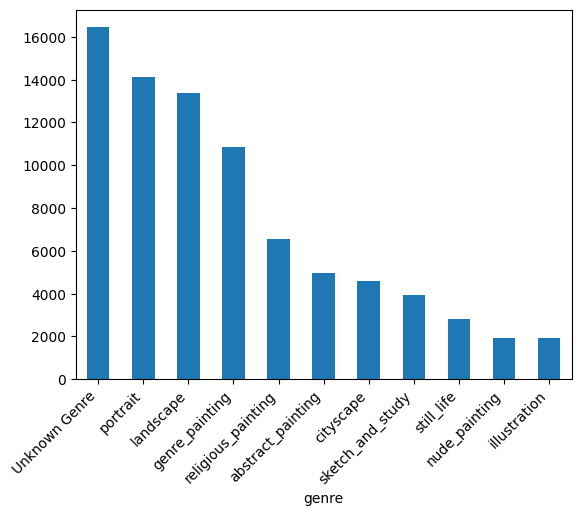

In [5]:
ax = genre_count.plot.bar()
ax.set_xticklabels(genre_count.index, rotation=45, ha='right')
genre_count

style
Impressionism                 13060
Realism                       10733
Romanticism                    7019
Expressionism                  6736
Post_Impressionism             6450
Symbolism                      4528
Art_Nouveau                    4334
Baroque                        4240
Abstract_Expressionism         2782
Northern_Renaissance           2552
Naive_Art_Primitivism          2405
Cubism                         2235
Rococo                         2089
Color_Field_Painting           1615
Pop_Art                        1483
Early_Renaissance              1391
High_Renaissance               1343
Minimalism                     1337
Mannerism_Late_Renaissance     1279
Ukiyo_e                        1167
Fauvism                         934
Pointillism                     513
Contemporary_Realism            481
New_Realism                     314
Synthetic_Cubism                216
Analytical_Cubism               110
Action_painting                  98
Name: count, dtype: in

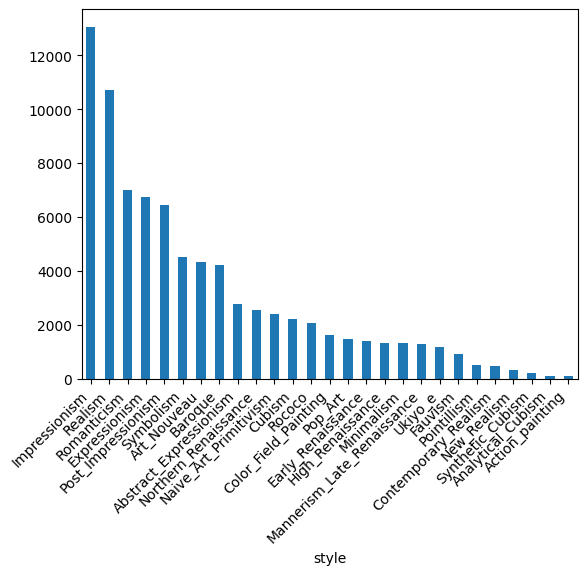

In [6]:
ax = style_count.plot.bar()
ax.set_xticklabels(style_count.index, rotation=45, ha='right')
style_count

In [7]:
combine_count = df.value_counts()
combine_count.index = combine_count.index.map(lambda x: (styles[x[0]], genres[x[1]]))
q3 = combine_count.quantile(0.90)
combine_count[combine_count > q3]

style                   genre             
Impressionism           landscape             4365
Realism                 landscape             2763
                        portrait              2703
Impressionism           genre_painting        2669
Abstract_Expressionism  abstract_painting     2208
Impressionism           portrait              1899
Art_Nouveau             Unknown Genre         1753
Expressionism           portrait              1735
                        Unknown Genre         1672
Post_Impressionism      landscape             1665
Romanticism             Unknown Genre         1665
                        portrait              1636
Realism                 genre_painting        1595
Impressionism           cityscape             1545
                        Unknown Genre         1528
Color_Field_Painting    abstract_painting     1514
Symbolism               Unknown Genre         1376
Realism                 Unknown Genre         1334
Northern_Renaissance    religious_paint

In [8]:
all_combi = set(product(styles, genres))
exist_combi = set(combine_count.index.tolist())
missing_combi = all_combi - exist_combi
missing_combi

{('Action_painting', 'cityscape'),
 ('Action_painting', 'genre_painting'),
 ('Action_painting', 'illustration'),
 ('Action_painting', 'landscape'),
 ('Action_painting', 'portrait'),
 ('Action_painting', 'religious_painting'),
 ('Action_painting', 'sketch_and_study'),
 ('Action_painting', 'still_life'),
 ('Analytical_Cubism', 'Unknown Genre'),
 ('Analytical_Cubism', 'abstract_painting'),
 ('Analytical_Cubism', 'illustration'),
 ('Analytical_Cubism', 'religious_painting'),
 ('Analytical_Cubism', 'sketch_and_study'),
 ('Art_Nouveau', 'abstract_painting'),
 ('Color_Field_Painting', 'cityscape'),
 ('Color_Field_Painting', 'genre_painting'),
 ('Color_Field_Painting', 'landscape'),
 ('Color_Field_Painting', 'nude_painting'),
 ('Color_Field_Painting', 'portrait'),
 ('Color_Field_Painting', 'religious_painting'),
 ('Color_Field_Painting', 'sketch_and_study'),
 ('Color_Field_Painting', 'still_life'),
 ('Contemporary_Realism', 'illustration'),
 ('Contemporary_Realism', 'religious_painting'),
 ('E

In [9]:
filtered_combi = {combi for combi in exist_combi if combi[1] != 'Unknown Genre'}
print(len(filtered_combi))
filtered_combi

218


{('Abstract_Expressionism', 'abstract_painting'),
 ('Abstract_Expressionism', 'cityscape'),
 ('Abstract_Expressionism', 'genre_painting'),
 ('Abstract_Expressionism', 'illustration'),
 ('Abstract_Expressionism', 'landscape'),
 ('Abstract_Expressionism', 'nude_painting'),
 ('Abstract_Expressionism', 'portrait'),
 ('Abstract_Expressionism', 'religious_painting'),
 ('Abstract_Expressionism', 'sketch_and_study'),
 ('Abstract_Expressionism', 'still_life'),
 ('Action_painting', 'abstract_painting'),
 ('Action_painting', 'nude_painting'),
 ('Analytical_Cubism', 'cityscape'),
 ('Analytical_Cubism', 'genre_painting'),
 ('Analytical_Cubism', 'landscape'),
 ('Analytical_Cubism', 'nude_painting'),
 ('Analytical_Cubism', 'portrait'),
 ('Analytical_Cubism', 'still_life'),
 ('Art_Nouveau', 'cityscape'),
 ('Art_Nouveau', 'genre_painting'),
 ('Art_Nouveau', 'illustration'),
 ('Art_Nouveau', 'landscape'),
 ('Art_Nouveau', 'nude_painting'),
 ('Art_Nouveau', 'portrait'),
 ('Art_Nouveau', 'religious_painti

In [10]:
df_select = pd.read_parquet(f'{data_path}/train-00002-of-00072.parquet', columns=['image', 'style', 'genre'])
df_select['genre'] = df_select['genre'].map(lambda x: genres[x])
df_select['style'] = df_select['style'].map(lambda x: styles[x])

In [11]:
imp_land = df_select[(df_select['style'] == 'Abstract_Expressionism') & (df_select['genre'] == 'abstract_painting')]

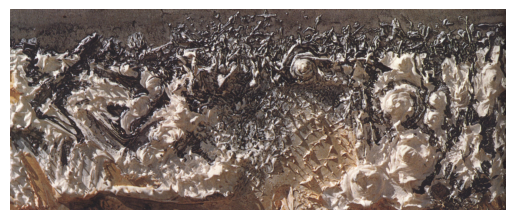

In [12]:
image = Image.open(BytesIO(imp_land.iloc[0]['image']['bytes']))
plt.imshow(image)
plt.axis('off')
plt.savefig('absexp_abspaint.jpg')

In [13]:
filtered_combi_dict = {}

for combi in filtered_combi:
    key, value = combi[0], combi[1]
    if key in filtered_combi_dict:
        filtered_combi_dict[key].append(value)
    else:
        filtered_combi_dict[key] = [value]

filtered_combi_dict

{'Baroque': ['religious_painting',
  'genre_painting',
  'still_life',
  'nude_painting',
  'portrait',
  'sketch_and_study',
  'cityscape',
  'abstract_painting',
  'landscape',
  'illustration'],
 'Cubism': ['portrait',
  'sketch_and_study',
  'landscape',
  'cityscape',
  'abstract_painting',
  'genre_painting',
  'nude_painting',
  'illustration',
  'religious_painting',
  'still_life'],
 'New_Realism': ['genre_painting',
  'nude_painting',
  'illustration',
  'portrait',
  'sketch_and_study',
  'landscape',
  'cityscape'],
 'Synthetic_Cubism': ['landscape',
  'cityscape',
  'abstract_painting',
  'still_life',
  'genre_painting',
  'portrait',
  'sketch_and_study'],
 'Mannerism_Late_Renaissance': ['genre_painting',
  'religious_painting',
  'still_life',
  'nude_painting',
  'portrait',
  'sketch_and_study',
  'landscape',
  'cityscape'],
 'Rococo': ['illustration',
  'portrait',
  'sketch_and_study',
  'landscape',
  'cityscape',
  'religious_painting',
  'genre_painting',
  'sti

In [19]:
# number of images to be generated for each style
each_style_images = 604
n_styles = len(filtered_combi_dict)

In [18]:
n_images = 0
for style in filtered_combi_dict:
    n_combi = len(filtered_combi_dict[style])
    each_combi_images = each_style_images // n_combi
    for genre in filtered_combi_dict[style]:
        n_images += each_combi_images
    n_images += each_style_images - each_combi_images*n_combi
n_images

60
60
86
86
75
67
60
67
67
67
86
60
67
60
67
67
302
60
302
201
60
67
75
75
100
60
75


16308

In [2]:
# pipe = DiffusionPipeline.from_pretrained("stabilityai/stable-diffusion-xl-base-1.0", torch_dtype=torch.float16, use_safetensors=True, variant="fp16")
file_path = "./stable-diffusion-webui/models/Stable-diffusion/v1-5-pruned-emaonly.safetensors"
pipe = StableDiffusionPipeline.from_single_file(file_path)
pipe.to("cuda")
pipe.enable_model_cpu_offload()

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


In [3]:
prompt = f'Baroque, religious_painting'
h = 512
w = 512
images = pipe(
    prompt=prompt,
    height=h,
    width=w
).images[0]

  0%|          | 0/50 [00:00<?, ?it/s]

C:\Users\eugen\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\diffusers\models\attention_processor.py:1244: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:263.)
  hidden_states = F.scaled_dot_product_attention(


In [4]:
images.save('image.jpg')